In [4]:
import pandas as pd
import numpy as np
import re
import nltk
import json

from collections import Counter

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

## Reading Dataset

In [6]:
df = pd.read_csv('tweetsLabeledFixed.csv')
df.head()

,preprocessed_tweets,tweet_content,tweet_label,confidence
0,menurutmu salah mbg,Apa yang menurutmu salah dari MBG? https://t.c...,negative,0.999151
1,surat edaran proyek makan beracun gratis mbg p...,Surat Edaran Proyek Makan Beracun Gratis (MBG)...,negative,0.972376
2,korban keracunan mbg berjatuhan ribuan siswa k...,Korban keracunan MBG masih terus berjatuhan.\n...,neutral,0.996815
3,mbg bukti paripurna jeleknya kualitas kompeten...,MBG adalah bukti paripurna jeleknya kualitas d...,negative,0.999448
4,menteri keuangan purbaya yudhi sadewa menarik ...,Menteri Keuangan Purbaya Yudhi Sadewa bakal me...,neutral,0.998951


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4820 entries, 0 to 4819
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   preprocessed_tweets  4820 non-null   object 
 1   tweet_content        4820 non-null   object 
 2   tweet_label          4820 non-null   object 
 3   confidence           4820 non-null   float64
dtypes: float64(1), object(3)
memory usage: 150.8+ KB


There are 4820 rows and 4 columns in the Final Dataset

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.isna().sum()

,0
preprocessed_tweets,0
tweet_content,0
tweet_label,0
confidence,0


There are no duplicated and missing data.

In [10]:
df['tweet_label'].value_counts()

,count
tweet_label,
neutral,2495
negative,1261
positive,1064


There are three classes for this 'Makan Bergizi Gratis' or MBG sentiment, which are Positive (consists of 1064 data, the category with least amount of data), negative (consists of 1261 data), and neutral (consists of 2495 data, which is the category with most data)

## Reading Slangs

In [11]:
with open('slangs.json', 'r') as file:
    slangs = json.load(file)

slangs

{'aamiin': 'amin',
 'adek': 'adik ',
 'adlh': 'adalah',
 'aer': 'air ',
 'aiskrim': 'es krim ',
 'aj': 'saja',
 'aja': 'saja',
 'ajah': 'saja ',
 'ajalah': 'saja ',
 'aje': 'saja ',
 'ajh': 'saja',
 'ajj': 'saja',
 'aku': 'saya',
 'ak': 'saya',
 'akoh': 'saya',
 'akutu': 'saya',
 'aq': 'saya',
 'alesan': 'alasan ',
 'ama': 'sama',
 'amaca': 'ah masa',
 'amuh': 'kamu',
 'ancur': 'hancur',
 'ane': 'saya ',
 'anget': 'hangat ',
 'anjeng': 'anjing ',
 'ank': 'anak',
 'apah': 'apa ',
 'aph': 'apa',
 'apo': 'apa ',
 'apose': 'apa',
 'apz': 'apa',
 'artine': 'artinya ',
 'asek': 'asyik',
 'ati2': 'hati-hati ',
 'atit': 'sakit ',
 'atu': 'satu ',
 'atw': 'atau ',
 'ayang': 'sayang',
 'ayuk': 'ayo ',
 'babang': 'abang',
 'bae': 'baik ',
 'bais': 'habis',
 'bakalan': 'akan',
 'bales': 'balas',
 'bandingin': 'bandingkan ',
 'banget': 'sekali ',
 'bangett': 'sangat ',
 'banyakin': 'perbanyak ',
 'barengan': 'bersamaan ',
 'baryaw': 'sabar ya',
 'baso': 'bakso ',
 'bay': 'selamat tinggal',
 'bbrp':

Since data was scraped from X (formerly Twitter), most of the posts are in slangs or informal language. Therefore, there should be some preprocessing done to handle the slangs as well. Two datasets from kaggle was retrieved and combine to replace the slangs into formal words.

## Stemmer and Stopwords

In [12]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

stopwordsList = set(stopwords.words('indonesian'))

In [13]:
stopwordsList

{'ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'berdatangan',
 'beri',
 'berikan',
 'berikut'

The words used in X post will be replaced with its basic form by utilizing stemmer, then the stopwords will be removed as well.

## Data Splitting and Encoding

Dataset will be split into x and y, where x is the tweet_content and y is the tweet_label column. In this project, the data will be split with a ratio of 4:1 for training and testing.

In [14]:
x = df['tweet_content']
y = df['tweet_label']

In [15]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

print(xTrain.shape, yTrain.shape)
print(xTest.shape, yTest.shape)

(3856,) (3856,)
(964,) (964,)


After splitting, it could be seen that the value has been split properly (both x and y has the same number of datas) and there are 3857 datas for training and 965 for testing.

### Encoding

In [16]:
enc = LabelEncoder()
yTrain = enc.fit_transform(yTrain)
yTest = enc.transform(yTest)

Since the sentiment is still as categorical data (neutral, positive, and negative), both yTrain and yTest will be encoded using LabelEncoder so it is usable for both Machine Learning Model: RandomForest Classifier and XGBoost Classifier

## Data Preprocessing

Before data is preprocessed, the frequency of words will be checked beforehand. This is to prevent insignificant words that often occurs, affecting the sentiment prediction. It could be seen that there are some insignificant words such as 'makan', 'program', 'perintah', etc. Therefore, these words will be used as custom stopwords. This process is done thrice, where the first two results are as shown in the image below:

![WhatsApp Image 2025-11-26 at 11.36.36_6ca05748.jpg](<attachment:WhatsApp Image 2025-11-26 at 11.36.36_6ca05748.jpg>)
![WhatsApp Image 2025-11-26 at 13.07.49_b1d57993.jpg](<attachment:WhatsApp Image 2025-11-26 at 13.07.49_b1d57993.jpg>)
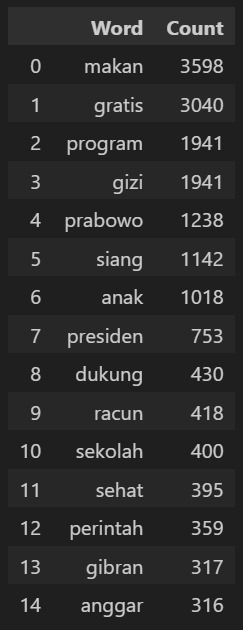
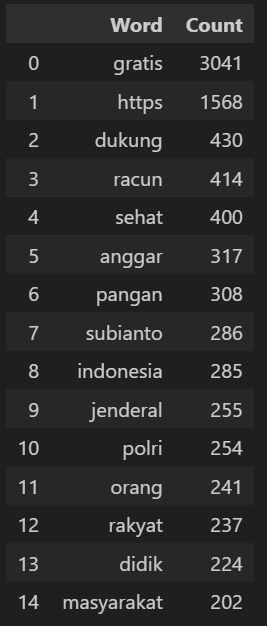

In [17]:
xTrainWords = []
customStopwords = ['makan', 'program', 'gizi', 'prabowo', 'siang', 'anak', 'presiden', 'sekolah', 'perintah', 'gibran', 'subianto', 'indonesia', 'jenderal', 'polri', 'wujud']

for i in xTrain:
    twt = i.casefold()
    twt = re.sub(r'http\S+|www\S+|https\S+', '', twt)
    twt = re.sub(r'@\w+|#\w+', '', twt)
    twt = re.sub(r'\d+', '', twt)
    twt = re.sub(r'[\W]', ' ', twt)
    twt = re.sub(r'([a-zA-Z])\1{2,}', r'\1', twt)
    twt = re.sub(r'\s+', ' ', twt).strip()9

    wordTokens = word_tokenize(twt)
    twt = [slangs.get(word, word) for word in twt]

    for word in wordTokens:
        stemmedWord = stemmer.stem(word)
        if word not in stopwordsList and len(word) > 3 and word not in customStopwords:
            xTrainWords.append(word)

xTrainCount = Counter(xTrainWords).most_common(15)
xTrainCountDf = pd.DataFrame(xTrainCount, columns=['Word', 'Count'])

xTrainCountDf

,Word,Count
0,gratis,2997
1,bergizi,1645
2,keracunan,340
3,pangan,321
4,mendukung,304
5,pemerintah,300
6,anggaran,298
7,makanan,245
8,rakyat,226
9,pendidikan,199


The table above shows the third process, where most of the words are likely to be significant in sentiment analysis. Therefore, the preprocessing step could be done, since the custom stopwords have been made.

In [18]:
def preprocessTwt(twts):
    tempListB = []
    tempListE = []

    for twt in twts:
        twt = twt.casefold()
        twt = re.sub(r'http\S+|www\S+|https\S+', '', twt)
        twt = re.sub(r'@\w+|#\w+', '', twt)
        twt = re.sub(r'\d+', '', twt)
        twt = re.sub(r'[\W]', ' ', twt)
        twt = re.sub(r'([a-zA-Z])\1{2,}', r'\1', twt)
        twt = re.sub(r'\s+', ' ', twt).strip()

        wordTokens = word_tokenize(twt)
        twt = [slangs.get(word, word) for word in twt]

        cleanedToken = []
        for word in wordTokens:
            stemmedWord = stemmer.stem(word)
            if word not in stopwordsList and len(word) > 3 and word not in customStopwords and word not in cleanedToken:
                cleanedToken.append(stemmedWord)

        tempListB.append(' '.join(cleanedToken))
        tempListE.append(cleanedToken)

    return tempListB, tempListE

In [19]:
prepBTrain, prepETrain = preprocessTwt(xTrain)
prepBTest, prepETest = preprocessTwt(xTest)

Both xTrain and xTest will be prepared and submitted to preProcessTwt function to ensure the datas are usable for the Text Representation Models such as Frequency-Based and Word-Embeddings.

Frequency-based requires the datas to be in sentences, meanwhile Word-Embeddings requires the datas to be in tokens instead.

In [20]:
print(xTrain[4])
print(prepBTrain[4])
print(prepETrain[4])

print()

print(xTest.iloc[5])
print(prepBTest[5])
print(prepETest[5])

Menteri Keuangan Purbaya Yudhi Sadewa bakal menarik kembali anggaran belanja kementerian/lembaga yang tak terserap. 

Semua kementerian/lembaga bakal disisir, termasuk anggaran program makan bergizi gratis (MBG). https://t.co/lvJAgWbeYJ
panitia gizi gratis mending studi banding undip mayan stuban dapet ilmu ngabisin anggar
['panitia', 'gizi', 'gratis', 'mending', 'studi', 'banding', 'undip', 'mayan', 'stuban', 'dapet', 'ilmu', 'ngabisin', 'anggar']

Lalu dalam 100 hari pertama pemerintahannya Prabowo-Gibran meluncurkan program makan siang gratis. Namun pada hari-hari awal program ini berjalan menu yang disajikan belum memenuhi standar kebutuhan gizi. https://t.co/arlE1ufv41
perintah luncur gratis jalan menu saji penuh standar butuh
['perintah', 'luncur', 'gratis', 'jalan', 'menu', 'saji', 'penuh', 'standar', 'butuh']


An example of preprocessing from Original tweet to text ready to use for text representation.

## Text Representation

There are two methods for Frequency-Based model: TF-IDF and BoW. Both are set to create features which are limited to 7500. And for TF-IDF, an additional parameter (n-gram) is set (1, 3), so the maximum length a phrase could create is up to 3-word-phrase.

In [21]:
tfidf = TfidfVectorizer(max_features=7500, ngram_range=(1, 3))
xTrainTf = tfidf.fit_transform(prepBTrain)
xTestTf = tfidf.transform(prepBTest)

In [22]:
bow = CountVectorizer(max_features=7500)
xTrainBow = bow.fit_transform(prepBTrain)
xTestBow = bow.transform(prepBTest)

Meanwhile for Word-Embeddings, the models used are Word2Vec, FastText, and GloVe. Both Word2Vec and FastText models will be created using dataset owned, meanwhile GloVe will be using a pre-trained model for Bahasa Indonesia. Since this project will be using Machine Learning, therefore, an average of each vector have to be retrieved, because ML can't accept multi-dimensional input.

In [23]:
def averageVectorValue(token, model):
    vector = [model.wv[word] for word in token if word in model.wv]
    if len(vector) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vector, axis=0)

A function created to get the average value of each vector

In [24]:
w2v = Word2Vec(sentences=prepETrain, vector_size=100, window=5, min_count=2, workers=4)

In [25]:
xTrainW2V = np.array([averageVectorValue(token, w2v) for token in prepETrain])
xTestW2V = np.array([averageVectorValue(token, w2v) for token in prepETest])

In [26]:
fasttext = FastText(sentences=prepETrain, vector_size=100, window=5, min_count=2, sg=1, workers=4, epochs=10)

In [27]:
xTrainFt = np.array([averageVectorValue(token, fasttext) for token in prepETrain])
xTestFt = np.array([averageVectorValue(token, fasttext) for token in prepETest])

In [39]:
glove2word2vec(glove_input_file="/content/drive/My Drive/Dataset/ProjectTM/glove_50dim_wiki.id.case.text.txt", word2vec_output_file="gloveVector.txt")

glove = KeyedVectors.load_word2vec_format("gloveVector.txt", binary=False)

/tmp/ipython-input-933676345.py:1: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file="/content/drive/My Drive/Dataset/ProjectTM/glove_50dim_wiki.id.case.text.txt", word2vec_output_file="gloveVector.txt")


In [40]:
def getVector(tokens):
  words = [word for word in tokens if word in glove]
  if not words:
    return np.zeros(glove.vector_size)
  return np.mean([glove[word] for word in words], axis=0)

In [41]:
xTrainGlove = np.array([getVector(token) for token in prepETrain])
xTestGlove = np.array([getVector(token) for token in prepETest])

## Machine Learning Modeling

The Machine Learning model used in this project are Random Forest and XGBoost. Every result will be saved in a dictionary named 'result'. Meanwhile for Finetune model results will be kept in resultFinetune dictionary.

In [56]:
result = {}
resultFinetune = {}

In [57]:
yTestInv = enc.inverse_transform(yTest)

### a. Baseline Model

In [58]:
def rfClassifier(xTrain, yTrain, xTest, n, method):
    rfModel = RandomForestClassifier(random_state=42)
    rfModel.fit(xTrain, yTrain)

    yPred = rfModel.predict(xTest)
    yPredInv = enc.inverse_transform(yPred)

    result[n] = {
        'Text Representation' : method,
        'Algoritma Machine Learning' : 'Random Forest Classifier',
        'Hyperparameter' : 'None',
        'Accuracy' : round(accuracy_score(yTestInv, yPredInv), 3),
        'F1-Score' : round(f1_score(yTestInv, yPredInv, average='macro'), 3),
        'Precision' : round(precision_score(yTestInv, yPredInv, average='macro'), 3),
        'Recall' : round(recall_score(yTestInv, yPredInv, average='macro'), 3)
    }

    print(method, 'Random Forest Classification Report:')
    print(classification_report(yTestInv, yPredInv, zero_division=0))

    return rfModel

In [59]:
def xgbClassifier(xTrain, yTrain, xTest, n, method):
    xgbModel = XGBClassifier(
        random_state=42,
        objective='multi:softmax',
        num_class=3
    )
    xgbModel.fit(xTrain, yTrain)

    yPred = xgbModel.predict(xTest)
    yPredInv = enc.inverse_transform(yPred)

    result[n] = {
        'Text Representation' : method,
        'Algoritma Machine Learning' : 'XGB Classifier',
        'Hyperparameter' : 'None',
        'Accuracy' : round(accuracy_score(yTestInv, yPredInv), 3),
        'F1-Score' : round(f1_score(yTestInv, yPredInv, average='macro'), 3),
        'Precision' : round(precision_score(yTestInv, yPredInv, average='macro'), 3),
        'Recall' : round(recall_score(yTestInv, yPredInv, average='macro'), 3)
    }

    print('\n', method, 'XGBoost Classification Report:')
    print(classification_report(yTestInv, yPredInv, zero_division=0))

    return xgbModel

In [60]:
rfModelTf = rfClassifier(xTrainTf, yTrain, xTestTf, '1', 'TF-IDF')
xgbModelTf = xgbClassifier(xTrainTf, yTrain, xTestTf, '2', 'TF-IDF')

TF-IDF Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.56      0.63       278
     neutral       0.69      0.84      0.76       480
    positive       0.68      0.52      0.59       206

    accuracy                           0.69       964
   macro avg       0.69      0.64      0.66       964
weighted avg       0.69      0.69      0.68       964


 TF-IDF XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.58      0.64       278
     neutral       0.71      0.80      0.75       480
    positive       0.63      0.57      0.60       206

    accuracy                           0.69       964
   macro avg       0.68      0.65      0.66       964
weighted avg       0.69      0.69      0.69       964



In [61]:
rfModelBow = rfClassifier(xTrainBow, yTrain, xTestBow, '3', 'BoW')
xgbModelBow = xgbClassifier(xTrainBow, yTrain, xTestBow, '4', 'BoW')

BoW Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.49      0.58       278
     neutral       0.72      0.77      0.74       480
    positive       0.52      0.65      0.58       206

    accuracy                           0.67       964
   macro avg       0.65      0.64      0.64       964
weighted avg       0.68      0.67      0.66       964


 BoW XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.62      0.68       278
     neutral       0.71      0.87      0.78       480
    positive       0.76      0.52      0.62       206

    accuracy                           0.72       964
   macro avg       0.73      0.67      0.69       964
weighted avg       0.73      0.72      0.71       964



In [62]:
rfModelW2V = rfClassifier(xTrainW2V, yTrain, xTestW2V, '5', 'Word2Vec')
xgbModelW2V = xgbClassifier(xTrainW2V, yTrain, xTestW2V, '6', 'Word2Vec')

Word2Vec Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.57      0.50      0.53       278
     neutral       0.60      0.76      0.67       480
    positive       0.57      0.32      0.41       206

    accuracy                           0.59       964
   macro avg       0.58      0.53      0.54       964
weighted avg       0.59      0.59      0.58       964


 Word2Vec XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.55      0.47      0.51       278
     neutral       0.62      0.75      0.68       480
    positive       0.56      0.38      0.45       206

    accuracy                           0.59       964
   macro avg       0.58      0.54      0.55       964
weighted avg       0.59      0.59      0.58       964



In [63]:
rfModelFt = rfClassifier(xTrainFt, yTrain, xTestFt, '7', 'FastText')
xgbModelFt = xgbClassifier(xTrainFt, yTrain, xTestFt, '8', 'FastText')

FastText Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.62      0.64       278
     neutral       0.69      0.80      0.74       480
    positive       0.64      0.47      0.54       206

    accuracy                           0.68       964
   macro avg       0.67      0.63      0.64       964
weighted avg       0.67      0.68      0.67       964


 FastText XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.63      0.63      0.63       278
     neutral       0.70      0.75      0.73       480
    positive       0.62      0.50      0.56       206

    accuracy                           0.66       964
   macro avg       0.65      0.63      0.64       964
weighted avg       0.66      0.66      0.66       964



In [64]:
rfModelGlove = rfClassifier(xTrainGlove, yTrain, xTestGlove, '9', 'Glove')
xgbModelGlove = xgbClassifier(xTrainGlove, yTrain, xTestGlove, '10', 'Glove')

Glove Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.54      0.62       278
     neutral       0.68      0.87      0.77       480
    positive       0.69      0.47      0.55       206

    accuracy                           0.69       964
   macro avg       0.70      0.63      0.65       964
weighted avg       0.69      0.69      0.68       964


 Glove XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.62      0.65       278
     neutral       0.70      0.80      0.75       480
    positive       0.62      0.50      0.56       206

    accuracy                           0.69       964
   macro avg       0.67      0.64      0.65       964
weighted avg       0.68      0.69      0.68       964



### b. Finetuned Model

In [71]:
rfParam = {
    'max_depth' : [10, 20, 30],
    'n_estimators' : [100, 150, 200],
    'min_samples_split' : [2, 5, 10]
}

xgbParam = {
    'n_estimators' : [100, 200, 300],
    'max_depth' : [3, 5, 7, 9],
    'learning_rate' : [0.1, 0.05, 0.01]
}

In [72]:
def rfClassifierFinetuned(xTrain, yTrain, xTest, n, method):
    rfModel = RandomForestClassifier(random_state=42)
    rfModelFinetune = RandomizedSearchCV(rfModel, param_distributions=rfParam, scoring='f1_macro')
    rfModelFinetune.fit(xTrain, yTrain)

    bestModel = rfModelFinetune.best_estimator_
    bestParam = rfModelFinetune.best_params_

    yPred = bestModel.predict(xTest)
    yPredInv = enc.inverse_transform(yPred)

    resultFinetune[n] = {
        'Text Representation' : method,
        'Algoritma Machine Learning' : 'Random Forest Classifier',
        'Hyperparameter' : str(bestParam),
        'Accuracy' : round(accuracy_score(yTestInv, yPredInv), 3),
        'F1-Score' : round(f1_score(yTestInv, yPredInv, average='macro'), 3),
        'Precision' : round(precision_score(yTestInv, yPredInv, average='macro'), 3),
        'Recall' : round(recall_score(yTestInv, yPredInv, average='macro'), 3)
    }

    print(method, 'Best Params:', bestParam)
    print(method, 'Random Forest Classification Report:')
    print(classification_report(yTestInv, yPredInv, zero_division=0))

    return bestModel

In [73]:
def xgbClassifierFinetuned(xTrain, yTrain, xTest, n, method):
    xgbModel = XGBClassifier(
        random_state=42,
        objective='multi:softmax',
        num_class=3
    )
    xgbModelFinetune = RandomizedSearchCV(xgbModel, param_distributions=xgbParam, scoring='f1_macro')
    xgbModelFinetune.fit(xTrain, yTrain)

    bestModel = xgbModelFinetune.best_estimator_
    bestParam = xgbModelFinetune.best_params_

    yPred = bestModel.predict(xTest)
    yPredInv = enc.inverse_transform(yPred)

    resultFinetune[n] = {
        'Text Representation' : method,
        'Algoritma Machine Learning' : 'XGBoost Classifier',
        'Hyperparameter' : str(bestParam),
        'Accuracy' : round(accuracy_score(yTestInv, yPredInv), 3),
        'F1-Score' : round(f1_score(yTestInv, yPredInv, average='macro'), 3),
        'Precision' : round(precision_score(yTestInv, yPredInv, average='macro'), 3),
        'Recall' : round(recall_score(yTestInv, yPredInv, average='macro'), 3)
    }

    print(method, 'Best Params:', bestParam)
    print(method, 'XGBoost Classification Report:')
    print(classification_report(yTestInv, yPredInv, zero_division=0))

    return bestModel

In [74]:
rfModelTfFinetune = rfClassifierFinetuned(xTrainTf, yTrain, xTestTf, '1', 'TF-IDF Finetuned')
xgbModelTfFinetune = xgbClassifierFinetuned(xTrainTf, yTrain, xTestTf, '2', 'TF-IDF Finetuned')

TF-IDF Finetuned Best Params: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 30}
TF-IDF Finetuned Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.40      0.53       278
     neutral       0.60      0.96      0.73       480
    positive       0.92      0.22      0.36       206

    accuracy                           0.64       964
   macro avg       0.77      0.53      0.54       964
weighted avg       0.72      0.64      0.59       964

TF-IDF Finetuned Best Params: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1}
TF-IDF Finetuned XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.57      0.63       278
     neutral       0.71      0.79      0.75       480
    positive       0.59      0.57      0.58       206

    accuracy                           0.68       964
   macro avg       0.67      0.65      0.65       964
weighte

In [75]:
rfModelBowFinetune = rfClassifierFinetuned(xTrainBow, yTrain, xTestBow, '3', 'BoW Finetuned')
xgbModelBowFinetune = xgbClassifierFinetuned(xTrainBow, yTrain, xTestBow, '4', 'BoW Finetuned')

BoW Finetuned Best Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 30}
BoW Finetuned Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.33      0.46       278
     neutral       0.59      0.96      0.73       480
    positive       0.85      0.26      0.40       206

    accuracy                           0.63       964
   macro avg       0.74      0.52      0.53       964
weighted avg       0.70      0.63      0.58       964

BoW Finetuned Best Params: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1}
BoW Finetuned XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.61      0.66       278
     neutral       0.71      0.86      0.78       480
    positive       0.74      0.53      0.62       206

    accuracy                           0.72       964
   macro avg       0.72      0.67      0.69       964
weighted avg       0

In [85]:
rfModelW2VFinetune = rfClassifierFinetuned(xTrainW2V, yTrain, xTestW2V, '5', 'Word2Vec Finetuned')
xgbModelW2VFinetune = xgbClassifierFinetuned(xTrainW2V, yTrain, xTestW2V, '6', 'Word2Vec Finetuned')

Word2Vec Finetuned Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20}
Word2Vec Finetuned Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.55      0.47      0.51       278
     neutral       0.59      0.76      0.66       480
    positive       0.55      0.30      0.39       206

    accuracy                           0.58       964
   macro avg       0.57      0.51      0.52       964
weighted avg       0.57      0.58      0.56       964

Word2Vec Finetuned Best Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05}
Word2Vec Finetuned XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.52      0.46      0.49       278
     neutral       0.61      0.75      0.67       480
    positive       0.59      0.35      0.44       206

    accuracy                           0.58       964
   macro avg       0.57      0.52      0.53       964

In [76]:
rfModelFtFinetune = rfClassifierFinetuned(xTrainFt, yTrain, xTestFt, '7', 'FastText Finetuned')
xgbModelFtFinetune = xgbClassifierFinetuned(xTrainFt, yTrain, xTestFt, '8', 'FastText Finetuned')

FastText Finetuned Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20}
FastText Finetuned Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.66      0.63      0.65       278
     neutral       0.69      0.80      0.74       480
    positive       0.65      0.45      0.53       206

    accuracy                           0.68       964
   macro avg       0.67      0.63      0.64       964
weighted avg       0.67      0.68      0.67       964

FastText Finetuned Best Params: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05}
FastText Finetuned XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.65      0.63      0.64       278
     neutral       0.69      0.77      0.73       480
    positive       0.61      0.47      0.53       206

    accuracy                           0.66       964
   macro avg       0.65      0.62      0.63       964

In [86]:
rfModelGloveFinetune = rfClassifierFinetuned(xTrainGlove, yTrain, xTestGlove, '9', 'Glove Finetuned')
xgbModelGloveFinetune = xgbClassifierFinetuned(xTrainGlove, yTrain, xTestGlove, '10', 'Glove Finetuned')

Glove Finetuned Best Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 30}
Glove Finetuned Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.54      0.62       278
     neutral       0.68      0.87      0.77       480
    positive       0.69      0.47      0.55       206

    accuracy                           0.69       964
   macro avg       0.70      0.63      0.65       964
weighted avg       0.69      0.69      0.68       964

Glove Finetuned Best Params: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1}
Glove Finetuned XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.68      0.59      0.63       278
     neutral       0.70      0.82      0.76       480
    positive       0.64      0.50      0.56       206

    accuracy                           0.69       964
   macro avg       0.67      0.64      0.65       964
weighted avg

## Balancing Imbalanced Data

Since the data is pretty imbalanced (Negative:Neutral:Positive ~ 1:2:1), therefore another experiment is held to see whether by handling the imbalance data will result in a better performing model or not. The imbalance will be handled by adding class_weight = 'balanced' to the machine learning model. This method will give a bigger punishment to the model if it fails to predict a class with lower number of data.

In [91]:
resultBalanced = {}

In [92]:
def rfClassifierBalanced(xTrain, yTrain, xTest, n, method):
    rfModel = RandomForestClassifier(random_state=42, class_weight='balanced')
    rfModel.fit(xTrain, yTrain)

    yPred = rfModel.predict(xTest)
    yPredInv = enc.inverse_transform(yPred)

    resultBalanced[n] = {
        'Text Representation' : method,
        'Algoritma Machine Learning' : 'Random Forest Classifier',
        'Hyperparameter' : 'None',
        'Accuracy' : round(accuracy_score(yTestInv, yPredInv), 3),
        'F1-Score' : round(f1_score(yTestInv, yPredInv, average='macro'), 3),
        'Precision' : round(precision_score(yTestInv, yPredInv, average='macro'), 3),
        'Recall' : round(recall_score(yTestInv, yPredInv, average='macro'), 3)
    }

    print(method, 'Balanced Random Forest Classification Report:')
    print(classification_report(yTestInv, yPredInv, zero_division=0))

    return rfModel

In [93]:
def xgbClassifierBalanced(xTrain, yTrain, xTest, n, method):
    sampleWeight = compute_sample_weight(class_weight='balanced', y=yTrain)

    xgbModel = XGBClassifier(
        random_state=42,
        objective='multi:softmax',
        num_class=3
    )
    xgbModel.fit(xTrain, yTrain, sample_weight = sampleWeight)

    yPred = xgbModel.predict(xTest)
    yPredInv = enc.inverse_transform(yPred)

    resultBalanced[n] = {
        'Text Representation' : method,
        'Algoritma Machine Learning' : 'XGB Classifier',
        'Hyperparameter' : 'None',
        'Accuracy' : round(accuracy_score(yTestInv, yPredInv), 3),
        'F1-Score' : round(f1_score(yTestInv, yPredInv, average='macro'), 3),
        'Precision' : round(precision_score(yTestInv, yPredInv, average='macro'), 3),
        'Recall' : round(recall_score(yTestInv, yPredInv, average='macro'), 3)
    }

    print('\n', method, 'Balanced XGBoost Classification Report:')
    print(classification_report(yTestInv, yPredInv, zero_division=0))

    return xgbModel

In [94]:
rfModelTfBalanced = rfClassifierBalanced(xTrainTf, yTrain, xTestTf, '1', 'TF-IDF Balanced')
xgbModelTfBalanced = xgbClassifierBalanced(xTrainTf, yTrain, xTestTf, '2', 'TF-IDF Balanced')

TF-IDF Balanced Balanced Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.58      0.63       278
     neutral       0.70      0.79      0.74       480
    positive       0.60      0.56      0.58       206

    accuracy                           0.68       964
   macro avg       0.67      0.64      0.65       964
weighted avg       0.68      0.68      0.68       964


 TF-IDF Balanced Balanced XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.63      0.70      0.66       278
     neutral       0.79      0.63      0.70       480
    positive       0.53      0.70      0.60       206

    accuracy                           0.66       964
   macro avg       0.65      0.68      0.66       964
weighted avg       0.69      0.66      0.67       964



In [105]:
rfModelBowBalanced = rfClassifierBalanced(xTrainBow, yTrain, xTestBow, '3', 'BoW Balanced')
xgbModelBowBalanced = xgbClassifierBalanced(xTrainBow, yTrain, xTestBow, '4', 'BoW Balanced')

BoW Balanced Balanced Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.49      0.59       278
     neutral       0.72      0.75      0.74       480
    positive       0.50      0.67      0.57       206

    accuracy                           0.66       964
   macro avg       0.65      0.64      0.63       964
weighted avg       0.68      0.66      0.66       964


 BoW Balanced Balanced XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.64      0.74      0.69       278
     neutral       0.83      0.61      0.70       480
    positive       0.54      0.76      0.63       206

    accuracy                           0.68       964
   macro avg       0.67      0.71      0.68       964
weighted avg       0.71      0.68      0.68       964



In [97]:
rfModelW2VBalanced = rfClassifierBalanced(xTrainW2V, yTrain, xTestW2V, '5', 'W2V Balanced')
xgbModelW2VBalanced = xgbClassifierBalanced(xTrainW2V, yTrain, xTestW2V, '6', 'W2V Balanced')

W2V Balanced Balanced Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.56      0.46      0.50       278
     neutral       0.59      0.78      0.67       480
    positive       0.61      0.32      0.42       206

    accuracy                           0.59       964
   macro avg       0.59      0.52      0.53       964
weighted avg       0.59      0.59      0.57       964


 W2V Balanced Balanced XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.57      0.53      0.55       278
     neutral       0.64      0.70      0.67       480
    positive       0.51      0.46      0.48       206

    accuracy                           0.60       964
   macro avg       0.57      0.56      0.57       964
weighted avg       0.59      0.60      0.59       964



In [106]:
rfModelFtBalanced = rfClassifierBalanced(xTrainFt, yTrain, xTestFt, '7', 'FastText Balanced')
xgbModelFtBalanced = xgbClassifierBalanced(xTrainFt, yTrain, xTestFt, '8', 'FastText Balanced')

FastText Balanced Balanced Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.66      0.62      0.64       278
     neutral       0.68      0.80      0.74       480
    positive       0.65      0.45      0.53       206

    accuracy                           0.67       964
   macro avg       0.67      0.62      0.64       964
weighted avg       0.67      0.67      0.67       964


 FastText Balanced Balanced XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.60      0.63      0.62       278
     neutral       0.72      0.72      0.72       480
    positive       0.55      0.51      0.53       206

    accuracy                           0.65       964
   macro avg       0.63      0.62      0.62       964
weighted avg       0.65      0.65      0.65       964



In [107]:
rfModelGloveBalanced = rfClassifierBalanced(xTrainGlove, yTrain, xTestGlove, '9', 'Glove Balanced')
xgbModelGloveBalanced = xgbClassifierBalanced(xTrainGlove, yTrain, xTestGlove, '10', 'Glove Balanced')

Glove Balanced Balanced Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.47      0.58       278
     neutral       0.65      0.88      0.75       480
    positive       0.67      0.42      0.52       206

    accuracy                           0.67       964
   macro avg       0.68      0.59      0.61       964
weighted avg       0.68      0.67      0.65       964


 Glove Balanced Balanced XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.65      0.63      0.64       278
     neutral       0.73      0.76      0.74       480
    positive       0.59      0.55      0.57       206

    accuracy                           0.68       964
   macro avg       0.66      0.65      0.65       964
weighted avg       0.68      0.68      0.68       964



## Evaluation and Summary

In [109]:
pd.set_option('display.max_colwidth', 500)

rowOrder = [
    '1', '2',
    '5', '6',
    '3', '4',
    '7', '8',
    '9', '10'
]

In [110]:
resultDf = (pd.DataFrame(result).T).reindex(rowOrder)
resultDf = resultDf.drop('Hyperparameter', axis=1)
resultDf.style.format({col:'{:.3f}' for col in ['Accuracy', 'F1-Score', 'Precision', 'Recall']}).hide(axis='index')

Text Representation,Algoritma Machine Learning,Accuracy,F1-Score,Precision,Recall
TF-IDF,Random Forest Classifier,0.693,0.659,0.692,0.642
TF-IDF,XGB Classifier,0.690,0.662,0.679,0.652
Word2Vec,Random Forest Classifier,0.590,0.538,0.580,0.527
Word2Vec,XGB Classifier,0.592,0.546,0.576,0.535
BoW,Random Forest Classifier,0.666,0.636,0.652,0.639
BoW,XGB Classifier,0.722,0.691,0.735,0.670
FastText,Random Forest Classifier,0.676,0.641,0.667,0.628
FastText,XGB Classifier,0.665,0.637,0.649,0.630
Glove,Random Forest Classifier,0.691,0.647,0.697,0.627
Glove,XGB Classifier,0.686,0.653,0.672,0.641


Based on the result, Bag-of-Words (BoW) has the best performance for baseline model, where the machine learning model used is XGBoost. Its accuracy reaches 72% with F1-Score close to 70%. This shows that since counting the frequency of words are more likely to give a better result rather than paying attention to the semantic meaning of the words. This is reflected from both TF-IDF and BoW results that are better in average compared to Embedding methods (W2V, FastText, and GloVe).

However, it should be noted since GloVe was trained using a pre-trained model, unlike FastText and Word2Vec, it showed a beter performance compared the latter methods, with an accuracy around 69% and F1-score around 65% for Baseline Machine Learning Model. Making it the best Word Embedding Method and third best text representation method overall after BoW and TF-IDF.

In [111]:
resultFinetuneDf = (pd.DataFrame(resultFinetune).T).reindex(rowOrder)
resultFinetuneDf.style.format({col:'{:.3f}' for col in ['Accuracy', 'F1-Score', 'Precision', 'Recall']}).hide(axis='index')

Text Representation,Algoritma Machine Learning,Hyperparameter,Accuracy,F1-Score,Precision,Recall
TF-IDF Finetuned,Random Forest Classifier,"{'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 30}",0.639,0.540,0.765,0.526
TF-IDF Finetuned,XGBoost Classifier,"{'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1}",0.683,0.654,0.668,0.646
Word2Vec Finetuned,Random Forest Classifier,"{'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20}",0.578,0.522,0.565,0.511
Word2Vec Finetuned,XGBoost Classifier,"{'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05}",0.583,0.535,0.574,0.522
BoW Finetuned,Random Forest Classifier,"{'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 30}",0.629,0.529,0.737,0.516
BoW Finetuned,XGBoost Classifier,"{'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1}",0.717,0.686,0.723,0.667
FastText Finetuned,Random Forest Classifier,"{'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20}",0.676,0.639,0.667,0.627
FastText Finetuned,XGBoost Classifier,"{'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05}",0.665,0.633,0.650,0.623
Glove Finetuned,Random Forest Classifier,"{'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 30}",0.691,0.647,0.697,0.627
Glove Finetuned,XGBoost Classifier,"{'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1}",0.687,0.652,0.674,0.639


In an attempt to improve the performance of each Machine Learning Model, a hyperparameter finetuning was implemented for every text representation. However, the result showed Baseline Model performed better from both Accuracy and F1-Score wise. This shows that, the baseline model could predict better compared to the Finetuned model. However, the result is not significantly different. 

Bag of Words still performs the best for Finetuned Model, achieving an accuracy of 71.7% and F1-Score of 68.6%, which are a 0.5% decrease from the best baseline model performance. This result is pretty much acceptable, but still could be improved.

In [115]:
resultBalancedDf = (pd.DataFrame(resultBalanced).T).reindex(rowOrder)
resultBalancedDf = resultBalancedDf.drop('Hyperparameter', axis=1)
resultBalancedDf.style.format({col:'{:.3f}' for col in ['Accuracy', 'F1-Score', 'Precision', 'Recall']}).hide(axis='index')

Text Representation,Algoritma Machine Learning,Accuracy,F1-Score,Precision,Recall
TF-IDF Balanced,Random Forest Classifier,0.679,0.652,0.666,0.643
TF-IDF Balanced,XGB Classifier,0.665,0.655,0.650,0.677
W2V Balanced,Random Forest Classifier,0.586,0.530,0.586,0.516
W2V Balanced,XGB Classifier,0.598,0.566,0.573,0.562
BoW Balanced,Random Forest Classifier,0.661,0.633,0.654,0.639
BoW Balanced,XGB Classifier,0.682,0.676,0.672,0.706
FastText Balanced,Random Forest Classifier,0.673,0.636,0.666,0.622
FastText Balanced,XGB Classifier,0.652,0.624,0.625,0.623
Glove Balanced,Random Forest Classifier,0.666,0.613,0.682,0.593
Glove Balanced,XGB Classifier,0.678,0.651,0.656,0.647


By handling the imbalanced, it could be seen that most of the recalls got a higher score, however most of the F1-Score and Accuracy is lower. This is caused by precision score with a bigger decrease compared to recall score that is affected and got an increase in value. Therefore, by handling the imbalanced data, the best model is still Bag Of Words with XGB Classifier with the highest accuracy and F1-Score. Although FastText has a higher accuracy compared to BoW, it has a lower F1-Score compared to BoW, making BoW still the best text representation method.

To conclude, the best model, Bag of Words using XGB Classifier, performed quite well with a minimum of F1-Score at ~67.6% and highest value of F1-Score at 69%. The worst model also has F1-Score of 52%, which isn't that bad, but isn't that good either. This shows there still could be some improvement done across the three model, so it could give a better sentiment prediction. This could be caused by the dataset taken. Since the data used was taken from Twitter where most of the words used are informal and slangs, sometimes in local city languages (Javanese for example), the text preprocessing and representation might not perform well. Besides, the model IndoBERT used for labelling could also be the reason for this mediocre result.

## Examples

In [113]:
text1 = ['program makan sudah bagus, tapi perlu direvisi, tapi mayan bantu rakyat kecl sih yg gbisa beli makan', 'program jlekkkkk, malah bikin rakyat bergantungan sm pemerintah indo', 'mksi pak presiden udh bantu kasi kmi makan.. makananny bergizi, bersih, sehat, anak2 pd suka.., bagus deh poko e']

preprocessedB, preprocessedE = preprocessTwt(text1)
preprocessedE = np.array([getVector(token) for token in preprocessedE])

text1Pred = xgbModelGloveBalanced.predict(preprocessedE)
text1Pred = enc.inverse_transform(text1Pred)
text1Pred

array(['neutral', 'negative', 'positive'], dtype=object)